In [216]:
# -*- coding: utf-8 -*- 
import numpy as np 
import pandas as pd 
import re
import matplotlib.pyplot as plt 
import sklearn.metrics as mt 
from sklearn.tree import export_graphviz 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV 
import joblib 
from sklearn.metrics import confusion_matrix 


In [217]:
# 1. 모델 로드
np.set_printoptions(precision=4, suppress = True)

rnd_clf = joblib.load("kospi_model_test.pkl") 
print("\n< AI model: load >") 


< AI model: load >


In [218]:
 # 1. daily raw data 가져오기
df = pd.read_excel(r"total_raw.xlsx", sheet_name="kospi", header=0, index_col=0)


In [219]:
df.tail()

,kospi,원/달러 환율,원/엔 환율,국채 3년물,국채 10년물,PER,PBR,VKOSPI,treasury_10_3_diff,T10Y2Y,...,PPI_60,USA_Vehi_Sell_60,구리 선물_60,중국 고정자산투자(yoy)_60,중국 PMI_60,금 선물_60,MSCI_EMER_60,달러 인덱스_60,중국소매판매_60,중국 산업 생산_60
base_date,,,,,,,,,,,,,,,,,,,,,
2024-01-05,neutral,1315.4,906.14,3.284,3.400,18.88,0.93,17.80,0.063,-0.34,...,-0.000572,-0.000435,0.001646,-0.001982,-0.000375,0.001211,0.001455,-0.000874,0.014495,0.007297
2024-01-08,neutral,1316.0,912.78,3.298,3.435,18.81,0.93,17.77,0.044,-0.35,...,-0.000560,-0.000381,0.001619,-0.001925,-0.000375,0.001104,0.001450,-0.000879,0.014393,0.007606
2024-01-09,neutral,1315.7,914.16,3.256,3.348,18.76,0.93,17.42,0.068,-0.35,...,-0.000546,-0.000328,0.001570,-0.001862,-0.000375,0.001017,0.001448,-0.000880,0.014252,0.007888
2024-01-10,neutral,1320.1,911.39,3.269,3.346,18.62,0.92,16.79,0.077,-0.33,...,-0.000552,-0.000275,0.001519,-0.001794,-0.000373,0.000940,0.001458,-0.000882,0.014072,0.008143
2024-01-11,neutral,1312.9,902.68,3.227,3.339,18.60,0.92,17.14,0.076,-0.28,...,-0.000558,-0.000223,0.001454,-0.001719,-0.000370,0.000848,0.001487,-0.000871,0.013857,0.008371


In [220]:
df.info

<bound method DataFrame.info of               kospi  원/달러 환율   원/엔 환율  국채 3년물   국채 10년물     PER   PBR  VKOSPI  \
base_date                                                                       
2010-03-31  neutral   1131.3  1213.45    3.895     4.940  24.35  1.36   13.47   
2010-04-01  neutral   1126.4  1204.45    3.895     4.920  24.13  1.38   13.63   
2010-04-05  neutral   1123.1  1188.97    3.840     4.950  24.22  1.38   13.56   
2010-04-06  neutral   1123.2  1195.40    3.845     4.940  24.24  1.38   14.75   
2010-04-07  neutral   1120.5  1191.13    3.820     4.880  24.26  1.39   14.22   
...             ...      ...      ...      ...       ...    ...   ...     ...   
2024-01-05  neutral   1315.4   906.14    3.284     3.400  18.88  0.93   17.80   
2024-01-08  neutral   1316.0   912.78    3.298     3.435  18.81  0.93   17.77   
2024-01-09  neutral   1315.7   914.16    3.256     3.348  18.76  0.93   17.42   
2024-01-10  neutral   1320.1   911.39    3.269     3.346  18.62  0.92   16.79

In [222]:
# df = df.drop(columns="KOSPI지수")
# df = df.drop(columns="KOSPI지수_20")
# df = df.drop(columns="KOSPI지수_60")
column_names = [
    'construct',    
    # 'KOSPI Index',
    'Exchange Rate (KRW/USD)', 'Exchange Rate (KRW/JPY)',
    '3-Year Treasury Bond', '10-Year Treasury Bond', 'Price-to-Earnings Ratio', 
    'Price-to-Book Ratio', 'Volatility Index of KOSPI',
    '10-Year Treasury Bond Minus 3-Year Treasury Bond',
    '10-Year Treasury Yield Minus 2-Year Treasury Yield', 'USA Consumer Price Index', 
    'USA Employment Inflation', 'Yield Gap Percentage', 'Consumer Price Index', 
    'Export', 'West Texas Intermediate (WTI) Crude Oil Price', 
    '2-Year Treasury Constant Maturity Rate', '10-Year Treasury Constant Maturity Rate',
    'Treasury Inflation-Protected Securities (TIPS) Yield', 'Volatility Index (VIX)', 
    'Producer Price Index (PPI)', 'USA Vehicle Sales', 'Copper Futures',
    'China Fixed Asset Investment (Year-over-Year)', 
    'China Purchasing Managers\' Index (PMI)', 'Gold Futures', 
    'MSCI Emerging Markets Index', 'US Dollar Index', 'China Retail Sales',
    'China Industrial Production', 
    # 'KOSPI Index (20-day Moving Average)', 
    'Exchange Rate (KRW/USD) (20-day Moving Average)',
    'Exchange Rate (KRW/JPY) (20-day Moving Average)', 
    '3-Year Treasury Bond (20-day Moving Average)', 
    '10-Year Treasury Bond (20-day Moving Average)', 
    'Price-to-Earnings Ratio (20-day Moving Average)', 
    'Price-to-Book Ratio (20-day Moving Average)', 
    'Volatility Index of KOSPI (20-day Moving Average)',
    '10-Year Treasury Bond Minus 3-Year Treasury Bond (20-day Moving Average)', 
    '10-Year Treasury Yield Minus 2-Year Treasury Yield (20-day Moving Average)',
    'T10Y2Y_20', 'usa_cpi_20', 'us_e_infla_20', 'yield_gap(%)_20', 'cpi_20',
    'export_20', 'WTI_20', 'DGS2_20', 'DGS10_20', 'TIPS_20', 'VIX_20', 'PPI_20',
    'USA_Vehi_Sell_20', 'Copper Futures (20-day Moving Average)', 'China Fixed Asset Investment (Year-over-Year) (20-day Moving Average)',
    'China Purchasing Managers\' Index (PMI) (20-day Moving Average)', 'Gold Futures (20-day Moving Average)',
    'MSCI Emerging Markets Index (20-day Moving Average)', 'US Dollar Index (20-day Moving Average)',
    'China Retail Sales (20-day Moving Average)', 'China Industrial Production (20-day Moving Average)',
    # 'KOSPI Index (60-day Moving Average)', 
    'Exchange Rate (KRW/USD) (60-day Moving Average)',
    'Exchange Rate (KRW/JPY) (60-day Moving Average)', '3-Year Treasury Bond (60-day Moving Average)',
    '10-Year Treasury Bond (60-day Moving Average)', 'Price-to-Earnings Ratio (60-day Moving Average)',
    'Price-to-Book Ratio (60-day Moving Average)', 'VKOSPI (60-day Moving Average)',
    'Treasury 10-Year Minus 3-Year Differential (60-day Moving Average)',
    '10-Year Treasury Yield Minus 2-Year Treasury Yield (60-day Moving Average)',
    'USA Consumer Price Index (60-day Moving Average)', 'USA Employment Inflation (60-day Moving Average)',
    'Yield Gap Percentage (60-day Moving Average)', 'Consumer Price Index (60-day Moving Average)',
    'Export (60-day Moving Average)', 'West Texas Intermediate (WTI) Crude Oil Price (60-day Moving Average)',
    '2-Year Treasury Constant Maturity Rate (60-day Moving Average)',
    '10-Year Treasury Constant Maturity Rate (60-day Moving Average)',
    'Treasury Inflation-Protected Securities (TIPS) Yield (60-day Moving Average)',
    'Volatility Index (VIX) (60-day Moving Average)', 'Producer Price Index (PPI) (60-day Moving Average)',
    'USA Vehicle Sales (60-day Moving Average)', 'Copper Futures (60-day Moving Average)',
    'China Fixed Asset Investment (Year-over-Year) (60-day Moving Average)',
    'China Purchasing Managers\' Index (PMI) (60-day Moving Average)', 'Gold Futures (60-day Moving Average)',
    'MSCI Emerging Markets Index (60-day Moving Average)', 'US Dollar Index (60-day Moving Average)',
    'China Retail Sales (60-day Moving Average)', 'China Industrial Production (60-day Moving Average)'
]

def check_english_only_in_list(lst):
    for item in lst:
        if not item.isascii():
            return False
    return True

# 검사 실행
if check_english_only_in_list(column_names):
    print("주어진 목록에는 영어만 포함되어 있습니다.")
else:
    print("주어진 목록에는 영어 이외의 문자가 포함되어 있습니다.")

    
    

df.rename(columns=dict(zip(df.columns, column_names)), inplace=True)

print("facter type:\n %s " % df.columns)
print("갯수 : %i " %len(df.columns))

주어진 목록에는 영어만 포함되어 있습니다.
facter type:
 Index(['construct', 'Exchange Rate (KRW/USD)', 'Exchange Rate (KRW/JPY)',
       '3-Year Treasury Bond', '10-Year Treasury Bond',
       'Price-to-Earnings Ratio', 'Price-to-Book Ratio',
       'Volatility Index of KOSPI',
       '10-Year Treasury Bond Minus 3-Year Treasury Bond',
       '10-Year Treasury Yield Minus 2-Year Treasury Yield',
       'USA Consumer Price Index', 'USA Employment Inflation',
       'Yield Gap Percentage', 'Consumer Price Index', 'Export',
       'West Texas Intermediate (WTI) Crude Oil Price',
       '2-Year Treasury Constant Maturity Rate',
       '10-Year Treasury Constant Maturity Rate',
       'Treasury Inflation-Protected Securities (TIPS) Yield',
       'Volatility Index (VIX)', 'Producer Price Index (PPI)',
       'USA Vehicle Sales', 'Copper Futures',
       'China Fixed Asset Investment (Year-over-Year)',
       'China Purchasing Managers' Index (PMI)', 'Gold Futures',
       'MSCI Emerging Markets Index', 'US D

In [223]:
model_data_dropna = df.dropna()

if model_data_dropna.empty:
    print("error")
else:
    # 종속 변수(y) 및 독립 변수(X) 설정
    first_column_name = df.columns[0]
    y = model_data_dropna[first_column_name]
    X = model_data_dropna.drop(columns=[first_column_name])
print(X)

            Exchange Rate (KRW/USD)  Exchange Rate (KRW/JPY)  \
base_date                                                      
2010-03-31                   1131.3                  1213.45   
2010-04-01                   1126.4                  1204.45   
2010-04-05                   1123.1                  1188.97   
2010-04-06                   1123.2                  1195.40   
2010-04-07                   1120.5                  1191.13   
...                             ...                      ...   
2024-01-05                   1315.4                   906.14   
2024-01-08                   1316.0                   912.78   
2024-01-09                   1315.7                   914.16   
2024-01-10                   1320.1                   911.39   
2024-01-11                   1312.9                   902.68   

            3-Year Treasury Bond  10-Year Treasury Bond  \
base_date                                                 
2010-03-31                 3.895                 

In [224]:
print("\n<Current status>")

for col, score in zip(X.columns, X.iloc[-1]):
    print("{:18} : {:>8.3f}".format(col, score))
X_current = np.array(X.iloc[-1]).reshape(1,-1)


<Current status>
Exchange Rate (KRW/USD) : 1312.900
Exchange Rate (KRW/JPY) :  902.680
3-Year Treasury Bond :    3.227
10-Year Treasury Bond :    3.339
Price-to-Earnings Ratio :   18.600
Price-to-Book Ratio :    0.920
Volatility Index of KOSPI :   17.140
10-Year Treasury Bond Minus 3-Year Treasury Bond :    0.076
10-Year Treasury Yield Minus 2-Year Treasury Yield :   -0.280
USA Consumer Price Index :    0.034
USA Employment Inflation :    2.220
Yield Gap Percentage :    0.021
Consumer Price Index :    0.032
Export             :   -0.072
West Texas Intermediate (WTI) Crude Oil Price :   72.150
2-Year Treasury Constant Maturity Rate :    4.260
10-Year Treasury Constant Maturity Rate :    3.980
Treasury Inflation-Protected Securities (TIPS) Yield :    1.760
Volatility Index (VIX) :   12.440
Producer Price Index (PPI) :  242.917
USA Vehicle Sales  :   15.830
Copper Futures     :    3.776
China Fixed Asset Investment (Year-over-Year) :    0.029
China Purchasing Managers' Index (PMI) :   49

In [225]:
# 5. 현재 전망
print("\n< AI model: forecasting >") 
y_current_pred = rnd_clf.predict(X_current) 
print("forecast: ", y_current_pred) 


< AI model: forecasting >
forecast:  ['neutral']


In [226]:
# 주어진 데이터를 사용하여 각 클래스의 확률을 예측
prob_current = rnd_clf.predict_proba(X_current) 
y_names = rnd_clf.classes_

print("\n[class] : [prob]") 
max_prob = max(prob_current[0]) # 최대 확률 초기화
for name, prob in zip(y_names, prob_current[0]):
    print("{:7} : {:.2f}".format(name, prob))

# 최대 확률에 해당하는 클래스의 이름과 확률을 출력
max_prob_index = prob_current[0].argmax() # 최대 확률의 인덱스를 찾음
max_prob_class = y_names[max_prob_index] # 최대 확률에 해당하는 클래스의 이름
print("앞으로 %s 할 확률이 %f" % (max_prob_class, max_prob))
# auto: down    : down    : 0.28    neutral : 0.39  up      : 0.33앞으로 neutral 할 확률이 0.390000
# construct:down    : 0.39  neutral : 0.23  up      : 0.38  앞으로 down 할 확률이 0.390000
# capital_market: down    : 0.32   neutral : 0.35  up      : 0.33  앞으로 neutral 할 확률이 0.350000
# chemicals : down    : 0.39    neutral : 0.34  up      : 0.27  앞으로 down 할 확률이 0.390000
# equipment:down    : 0.42  neutral : 0.29  up      : 0.29  앞으로 down 할 확률이 0.420000
# media:down    : down    : 0.30    neutral : 0.35  up      : 0.35  앞으로 neutral 할 확률이 0.350000
# insurance:down    : 0.42  neutral : 0.39  up      : 0.19  앞으로 down 할 확률이 0.420000
# transport:down    : down    : 0.37    neutral : 0.40  up      : 0.23  앞으로 neutral 할 확률이 0.400000
# health_care:down    : 0.29    neutral : 0.36  up      : 0.35  앞으로 neutral 할 확률이 0.360000
# semi:down    :down    : 0.29  neutral : 0.37  up      : 0.34  앞으로 neutral 할 확률이 0.370000
# bank:down    : down    : 0.24 neutral : 0.38  up      : 0.38  앞으로 neutral 할 확률이 0.380000
# steel:down    : down    : 0.35    neutral : 0.26  up      : 0.39  앞으로 up 할 확률이 0.390000
# staples: down    : 0.34   neutral : 0.40  up      : 0.26  앞으로 neutral 할 확률이 0.400000
# discretionary:down    : 0.18  neutral : 0.53  up      : 0.29  앞으로 neutral 할 확률이 0.530000
# kospi:down    : 0.29  neutral : 0.48  up      : 0.23  앞으로 neutral 할 확률이 0.480000


[class] : [prob]
down    : 0.29
neutral : 0.48
up      : 0.23
앞으로 neutral 할 확률이 0.480000


In [227]:
# 전기간 전망치 확률 데이터생성
prob = rnd_clf.predict_proba(X) 
prob_df = pd.DataFrame(prob, index=y.index, columns=y_names) 

C:\Users\siim2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


C:\Users\siim2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


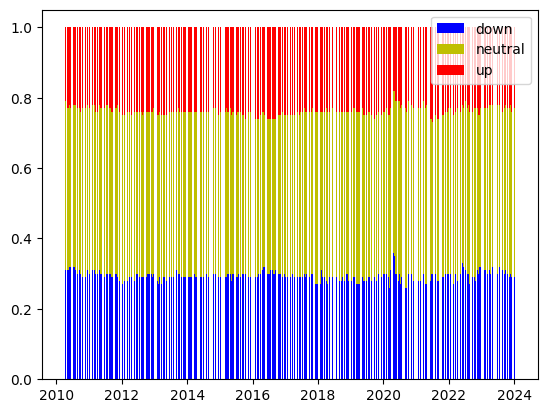

In [228]:
# 전망치 확률의 그래프 출력
prob_data = prob_df 
# 중립 값을 neutral로 설정


plt.bar(prob_data.index, prob_data['down'], label='down', color='b', bottom=0)
plt.bar(prob_data.index, prob_data['neutral'], label='neutral', color='y', bottom=prob_data['down'])
plt.bar(prob_data.index, prob_data['up'], label='up', color='r', bottom=prob_data['down'] + prob_data['neutral'])


# 범례 추가
plt.legend()

# 그래프 출력
plt.show()

### 이렇게 보면은 최근들어서 down 확률이 확 늘었다